# CS-UY 3943 - Introduction of Data Science
## Week 9: Classification II

Please edit the cell below to add your name, NetID, assigned group, and group members for this assignment. **Complete this section before proceeding to the assignment questions.**

Name:  Lenny Remache
NetID:  ljr381
Group (Letter):  E
Group Member 1:  kl364
Group Member 2:  mtk367
***

This assignment will continue where we left off from our last session. Again, we will be analyzing data generated by particle physicists to test whether machine learning can help classify certain particle decay experiments to identify the presence of a Higgs Boson. However, rather than using default parameter values for the classification models, we will instead use cross-validation for model selection. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm, linear_model, metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
def clean_boson_data(infile_name):
    
    df = pd.read_csv(infile_name, na_values = -999) # read in data set
    df.set_index(df['EventId']) # set index to EventId column
    numeric = {'Label':{'s': 1,'b': 0}} # used to replace categorical with numeric values
    df_label = df.replace(numeric)
    df['Y'] = df_label['Label'] # new numeric column Y for Label
    df = df.drop('Label', axis=1) # drop original Label column
    
    mean = {'DER_mass_MMC': { float('NaN') : np.nanmean(df['DER_mass_MMC']) },
            'DER_deltaeta_jet_jet': { float('NaN') : np.nanmean(df['DER_deltaeta_jet_jet']) },
            'DER_mass_jet_jet': { float('NaN') : np.nanmean(df['DER_mass_jet_jet']) },
            'DER_prodeta_jet_jet': { float('NaN') : np.nanmean(df['DER_prodeta_jet_jet']) }
           }
    df= df.replace(mean)
    
    columns = df.columns[1:-1]
    
    for column in columns:
        df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])
        
    return df

### Part 1: ROC AND AUC
In this part, you will generate ROC curves for your out-of-the box logistic regression (LR) and support vector machine (SVM) models. Out-of-the-box means that you build models without parameter tuning. 

1. Clean the two data files for this assignment (**boson_training_cut.csv** and **boson_testing_cut.csv**) as before and use them as training and testing data sets, respectively.

In [3]:
# place code here
training_set = clean_boson_data('boson_training_cut.csv')
testing_set = clean_boson_data('boson_testing_cut.csv')

In [4]:
training_set.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
0,100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,1
1,100001,8.633960e-01,0.608117,0.639363,-0.120744,-1.941583e-14,1.727761e-14,-4.734354e-15,1.421917,-0.806390,0
2,100002,-1.706033e-14,3.421843,1.261884,-0.321306,-1.941583e-14,1.727761e-14,-4.734354e-15,0.997693,-0.455521,0
3,100003,5.108589e-01,0.989159,0.028516,-0.885926,-1.941583e-14,1.727761e-14,-4.734354e-15,1.209152,-0.886831,0
4,100004,1.172363e+00,-0.953916,1.504447,-0.629578,-1.941583e-14,1.727761e-14,-4.734354e-15,1.967534,-0.113790,0


In [5]:
testing_set.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
0,300000,-1.213348e-01,1.455304,0.099593,-0.447028,-1.862816e-12,1.417688e-13,1.711651e-13,0.007415,0.498029,0
1,300001,-1.067373e+00,-0.715757,-0.854408,-0.103307,-1.862816e-12,1.417688e-13,1.711651e-13,-0.758743,1.730043,0
2,300002,-1.159847e-01,0.480365,0.064286,-0.297389,-2.874836e-01,6.645349e-01,-7.332925e-02,0.465570,0.505136,1
3,300003,8.355185e-01,0.476970,0.482975,-0.882260,-1.862816e-12,1.417688e-13,1.711651e-13,1.416531,-0.804583,0
4,300004,3.079217e-13,0.925326,-0.484386,-0.473912,-1.862816e-12,1.417688e-13,1.711651e-13,-0.195354,0.417565,0


2. Using the training set, build the following models:

* A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
* An SVM using sklearn's `svm.SVC()`. For this model, use `kernel="linear"`.

For each model, plot the ROC curve. Include the ROC curves on the same plot. Use the `decision_function()` method for each classifier to compute the target scores needed to compute the ROC curve. Make sure to use the test dataset for computing and plotting. In the legend, also include the Area Under the ROC Curve (AUC) for each classifier for reference.

In [6]:
# place code here
X_train = training_set.iloc[:,1:-1]
y_train = training_set['Y']

X_test = testing_set.iloc[:,1:-1]
y_test = testing_set['Y']

log_reg = linear_model.LogisticRegression(C=1e30).fit(X_train,y_train)
svm_model = svm.SVC(kernel='linear').fit(X_train,y_train)

In [7]:
logreg_decision = log_reg.decision_function(X_test)
svm_decision = svm_model.decision_function(X_test)

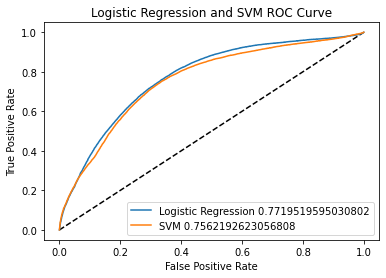

In [8]:
#y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, logreg_decision)
auc = roc_auc_score(y_test, logreg_decision)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_decision)
auc_svm = roc_auc_score(y_test, svm_decision)

_ = plt.plot([0, 1], [0, 1], 'k--')

_ = plt.plot(fpr, tpr, label='Logistic Regression '+str(auc))
_ = plt.plot(fpr_svm, tpr_svm, label='SVM '+str(auc_svm))

_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression and SVM ROC Curve')

_ = plt.legend()

plt.show();

3. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)? (HINT: You may want to increase the size of your plot above to more clearly see its contents).

<p>
<span style="color:blue">
Generally, the logistic regression model is better at ranking the test set because its AUC value or area under the curve is larger with a value of approximately 0.772 compared to SVM's auc value of 0.756. As far as what can be seen from the plots there is no postions in the tpr and fpr points where the svm model out performs the logistic model. There may be points where they perform the same but not where logistic regression performs worse tha svm.
</span>
</p>

### Part 2: A homemade cross-validation function
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  We will use cross-validation to find the optimal $C$.

1\. Write a cross-validation function (do not use any pre-existing cross-validation tools such as those defined in `sklearn.model_selection`):
- Takes as inputs a dataset, a label name (the column with target values), # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Randomly shuffles the data
- Splits the data into `k` approximately equal sized groups (folds)
- Performs two loops
  - Outer Loop (iterate over folds to determine which to hold out as test data):
    - Splits the data into `data_train` & `data_test` according to cross-validation logic
  - Inner Loop: (iterate over $C$ values with each $C$ used to build a different classifier:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_\<C\>_\<FOLD_ID\> on validation data (FOLD_ID_ corresponds to the hold-out fold)
    - Stores AUC_\<C\>_\<FOLD_ID\> in a dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]` (*c* is the chosen value for $C$ and the integer is the *FOLD_ID*)

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [10]:
mv_df = pd.DataFrame()
mv2_df = pd.DataFrame()
def clean_boson_data(infile_name,mv_df):
    df = pd.read_csv(infile_name, sep = ",")
    df["Y"] = df["Label"].map({"b":0,"s":1})
    df = df.drop(columns=['Label'])
    for (columnName,columnData) in df[df.columns[df.columns != 'EventId']].iteritems():
        booldf = df[columnName].isin([-999])
        mv_df[columnName + "_mv"] = booldf.map({True:0, False:1})
    df = df.replace(-999,np.nan)
    mean = df.mean()
    std = df.std()
    df = df.set_index("EventId")
    for (columnName,columnData)  in df[df.columns[df.columns != 'Y' ]].iteritems():
        df[columnName] = df[columnName].replace(np.nan,df[columnName].mean())
        df[columnName] = df[columnName] - df[columnName].mean()
        df[columnName] = df[columnName] / df[columnName].std()
    return df

testing_df = clean_boson_data("boson_testing_cut.csv",mv_df)
training_df = clean_boson_data("boson_training_cut.csv",mv2_df)
training_df.head(10)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
EventId,,,,,,,,,,
100000,3.982628e-01,0.092577,0.491050,-0.443910,-1.649712e+00,-1.135038e+00,1.872725e+00,0.887826,1.119770,1
100001,8.631800e-01,0.607965,0.639204,-0.120714,-1.941097e-14,1.671608e-14,-4.794640e-15,1.421561,-0.806188,0
100002,-2.058490e-14,3.420987,1.261568,-0.321225,-1.941097e-14,1.671608e-14,-4.794640e-15,0.997444,-0.455407,0
100003,5.107311e-01,0.988911,0.028509,-0.885705,-1.941097e-14,1.671608e-14,-4.794640e-15,1.208850,-0.886609,0
100004,1.172069e+00,-0.953678,1.504071,-0.629420,-1.941097e-14,1.671608e-14,-4.794640e-15,1.967041,-0.113761,0
100005,-6.100408e-01,-1.055020,-0.568542,0.972280,2.847184e-01,-3.514670e-01,9.765822e-02,-1.333245,2.071439,0
100006,6.110731e-01,-0.593873,0.763770,0.808583,-1.848087e+00,-9.701220e-01,4.592049e-01,0.727313,-0.783618,1
100007,7.385854e-01,-1.149346,0.405769,-0.424854,-1.941097e-14,1.671608e-14,-4.794640e-15,0.669894,-0.832866,1
100008,-2.820514e-01,0.059570,0.577674,-0.823617,-1.941097e-14,1.671608e-14,-4.794640e-15,0.679029,-0.699378,0


In [11]:
def cross_val_svm(dataset, label_name, k, cs):
    dataset = dataset.sample(frac = 1)
    sizeFold = len(dataset)//k
    aucs = {}
    for elem in cs:
        aucs[elem] = []
    for i in range(k):
        split_1 = dataset.iloc[0:sizeFold*i]
        split_2 = dataset.iloc[sizeFold*(i+1):-1]
        data_train = pd.concat([split_1, split_2])
        data_test = dataset.iloc[sizeFold*i: sizeFold*(i+1)]
        x_test = data_test.drop(columns = [label_name])
        y_test = data_test[label_name]
        for c in cs:
            x_train = data_train.drop(columns = [label_name])
            y_train = data_train[label_name]
            svc = svm.SVC(C=c,kernel = "linear").fit(x_train,y_train)
            y_pred = svc.decision_function(x_test)
            auc = roc_auc_score(y_test,y_pred)
            aucs[c].append(auc)
    return aucs

In [12]:
cross_val_svm(training_df, 'Y', 5, [.1,1,10])

{0.1: [0.7619630853366753,
  0.7600262048535946,
  0.747841726618705,
  0.6952278849854308,
  0.750088370448922],
 1: [0.7630454597242794,
  0.7664634841061866,
  0.7508577753182069,
  0.6969047226345593,
  0.7503829386119949],
 10: [0.7635296798450496,
  0.7667483194713456,
  0.7507747648035418,
  0.6969597009181374,
  0.7501767408978437]}

In [13]:
training_set.shape

(1999, 11)